# Memorial Day criminality analysis
***



## Business understanding
De politiechef van Denver wil een goed overzicht krijgen van de criminaliteit tijdens memorial day in Denver, zodat hij zijn manschappen beter kan verdelen in de stad.

### Determine business objectives
Het eerste wat uitgezocht moet worden is of er tijdens memorial day meer incidenten plaats vinden dan gemiddeld. Als dit het geval is, dan gaan wij verder kijken waar dit vandaan komt.

### Assess situation
Memorial Day is een Amerikaanse feest- en gedenkdag, **gehouden op de laatste maandag in mei**, waarop de overleden Amerikaanse militairen herdacht worden. De gedenkdag begon na de Amerikaanse Burgeroorlog om de doden die voor de Unie stierven tussen 1861 en 1865 te eren.

### Determine data mining goals
Verkrijg alle benodigde data uit de dataset met behulp van de datums van de Memorial Day en dit te vergelijking stellen met het gemiddelde van de gehele dataset.

## Data understanding
***
De code hieronder zorgt dat de rest van het notebook werkt op zowel Mac als Windows. Dit is een cruciale stap om deze notebook werkend te maken.

In [2]:
import platform
import os

# Get working directory
working_directory = os.getcwd()

# check if macos
isMac = "macos" in platform.platform().lower()

### Collect initial data
Onderstaand halen wij de 2 verschillende datasets op die nodig zijn voor deze analyse.

In [3]:
crime_file_path = (f"{working_directory}/data/crime.csv" if isMac else f"{working_directory}\\data\\crime.csv")
offense_file_path = f"{working_directory}/data/offense_codes.csv" if isMac else f"{working_directory}\\data\\offense_codes.csv"

### Describe data
De data kan worden benaderd met de paden die in bovenstaande cell staan. Dit doen we door ze in een Pandas Dataframe te stoppen, zoals hieronder. Hierna kun je in dit hele Jupyter Notebook gebruik maken van de dataframes.

In [4]:
import pandas as pd
import numpy as np
from datetime import datetime
from dateutil.relativedelta import relativedelta, MO
import seaborn as sns
import matplotlib.pyplot as plt

In [5]:
# Data in een dataframe te stoppen
crime_df = pd.read_csv(crime_file_path)
offense_df = pd.read_csv(offense_file_path)

### Explore data & Verify data quality
Voor verdere exploratie en verificatie, verwijs ik je graag naar de [algemene notebook](basic_data_understanding.ipynb).

## Data preparation
***
Als eerste gaan wij de data prepereren. Dit is nodig, omdat alle datums tot nu toe datums zijn met tijdsnotaties. Dit moeten wij eerst omzetten naar reguliere datums.

In [6]:
# Kopie maken van de offense dataset voor later gebruik.
memorialday_offense_df = offense_df.copy()

# Hier maken wij van de datum kolommen pandas readable DateTime kolommen om hier later makkelijker mee te kunnen werken.
crime_df["FIRST_OCCURRENCE_DATE"] = pd.to_datetime(crime_df["FIRST_OCCURRENCE_DATE"])
crime_df["LAST_OCCURRENCE_DATE"] = pd.to_datetime(crime_df["LAST_OCCURRENCE_DATE"])
crime_df["REPORTED_DATE"] = pd.to_datetime(crime_df["REPORTED_DATE"])

# Hier maken wij een nieuwe kolom van de `Reported Date` zonder de tijdsnotatie.
crime_df["REPORTED_DATE_NORMALIZED"] = crime_df["REPORTED_DATE"].dt.normalize()

memorialday_crime_df = crime_df.copy()
memorialday_crime_df.head()

,incident_id,offense_id,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,REPORTED_DATE_NORMALIZED
0,20226000193,20226000193299900,2999,0,criminal-mischief-other,public-disorder,2022-01-04 11:30:00,2022-01-04 12:00:00,2022-01-04 20:36:00,128 S CANOSA CT,3135366.0,1685410.0,-105.018825,39.714268,4.0,411.0,valverde,1,0,2022-01-04
1,20223319,20223319299900,2999,0,criminal-mischief-other,public-disorder,2022-01-03 06:45:00,NaT,2022-01-03 11:01:00,650 15TH ST,3142454.0,1696151.0,-104.993418,39.743649,6.0,611.0,cbd,1,0,2022-01-03
2,20223093,20223093299900,2999,0,criminal-mischief-other,public-disorder,2022-01-03 01:00:00,NaT,2022-01-03 06:11:00,919 E COLFAX AVE,3147484.0,1694898.0,-104.975557,39.740130,6.0,621.0,north-capitol-hill,1,0,2022-01-03
3,20224000,20224000299900,2999,0,criminal-mischief-other,public-disorder,2022-01-03 19:47:00,NaT,2022-01-03 21:12:00,2345 W ALAMEDA AVE,3136478.0,1684414.0,-105.014892,39.711518,4.0,411.0,valverde,1,0,2022-01-03
4,20223956,20223956299900,2999,0,criminal-mischief-other,public-disorder,2022-01-03 17:06:00,NaT,2022-01-03 20:31:00,7800 E SMITH RD,3169237.0,1705800.0,-104.897950,39.769688,5.0,512.0,central-park,1,0,2022-01-03


### Select data
Omdat Memorial day altijd op de laatste maandag van mei plaats vind, moeten wij dit eerst uitfilteren van de data die we hebben van de afgelopen jaren.

In [7]:
# Maak een pandas DataFrame met daarin alle datum
dates = pd.date_range(memorialday_crime_df["REPORTED_DATE"].min(), datetime.now())

# vars voor leesbaarheid
monday = 0
may = 5

# Krijg alle eerste maandagen van de datums
# dates = dates.shift(1, freq='WOM-4MON')
# dates = dates.unique()

# TODO: Dynamisch inladen van de laatste maandag van de maand.
allMemorialDays = ['2017-05-29', '2018-05-28', '2019-05-27', '2020-05-25', '2021-05-24', '2022-05-30']

# Krijg alle eerste maandagen uit september uit de al bewerkte datums
#mask = (dates.weekday == monday) & (dates.month == may) & np.array(dates.map(lambda v : v.strftime('%Y-%m-%d') in allMemorialDays))
#last_mondays = dates[mask]

# Convert mondays to a DataFrame and to dates only
last_mondays_df = pd.DataFrame()
last_mondays_df["REPORTED_DATE_NORMALIZED"] = pd.to_datetime(allMemorialDays)
last_mondays_df["REPORTED_DATE_NORMALIZED"] = pd.to_datetime(last_mondays_df["REPORTED_DATE_NORMALIZED"]).dt.normalize()
last_mondays_df



,REPORTED_DATE_NORMALIZED
0,2017-05-29
1,2018-05-28
2,2019-05-27
3,2020-05-25
4,2021-05-24
5,2022-05-30


In [8]:
# Verkrijg alle data die verbonden staat aan de laatste maandag van mei.
memorialday_crime_df = pd.merge(memorialday_crime_df, last_mondays_df, on="REPORTED_DATE_NORMALIZED")
memorialday_crime_df = memorialday_crime_df.sort_values("REPORTED_DATE_NORMALIZED")
memorialday_crime_df

,incident_id,offense_id,OFFENSE_CODE,OFFENSE_CODE_EXTENSION,OFFENSE_TYPE_ID,OFFENSE_CATEGORY_ID,FIRST_OCCURRENCE_DATE,LAST_OCCURRENCE_DATE,REPORTED_DATE,INCIDENT_ADDRESS,GEO_X,GEO_Y,GEO_LON,GEO_LAT,DISTRICT_ID,PRECINCT_ID,NEIGHBORHOOD_ID,IS_CRIME,IS_TRAFFIC,REPORTED_DATE_NORMALIZED
348,2017347915,2017347915131500,1315,0,aggravated-assault,aggravated-assault,2017-05-28 21:00:00,NaT,2017-05-29 04:09:00,3480 PARK AVEW,3142322.0,1704085.0,-104.993730,39.765431,1.0,112.0,globeville,1,0,2017-05-29
207,2017348941,2017348941410400,4104,0,liquor-possession,drug-alcohol,2017-05-29 15:50:00,NaT,2017-05-29 16:18:00,21ST ST / ARAPAHOE ST,3143501.0,1699391.0,-104.989630,39.752527,6.0,611.0,five-points,1,0,2017-05-29
206,2017349565,2017349565360500,3605,0,indecent-exposure,other-crimes-against-persons,2017-05-29 20:15:00,NaT,2017-05-29 20:15:00,NaN,3082712.0,1667296.0,-105.206197,39.665157,4.0,423.0,marston,1,0,2017-05-29
205,2017347780,2017347780357200,3572,0,drug-methampetamine-possess,drug-alcohol,2017-05-29 01:32:00,NaT,2017-05-29 02:48:00,2300 BLOCK W 27TH AVE,3136310.0,1700777.0,-105.015178,39.756440,1.0,113.0,highland,1,0,2017-05-29
204,2017347755,2017347755357200,3572,0,drug-methampetamine-possess,drug-alcohol,2017-05-29 00:30:00,NaT,2017-05-29 04:39:00,E 6TH AVE / N MAGNOLIA ST,3165494.0,1689621.0,-104.911637,39.725341,3.0,321.0,hilltop,1,0,2017-05-29
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
550,2021292014,2021292014220200,2202,0,burglary-residence-by-force,burglary,2021-05-24 05:04:00,NaT,2021-05-24 05:04:00,1265 N DOWNING ST,3148119.0,1693504.0,-104.973327,39.736294,6.0,623.0,capitol-hill,1,0,2021-05-24
551,2021292031,2021292031220200,2202,0,burglary-residence-by-force,burglary,2021-05-23 23:00:00,2021-05-24 04:18:00,2021-05-24 04:18:00,NaN,3153500.0,1688232.0,-104.954307,39.721734,3.0,311.0,cherry-creek,1,0,2021-05-24
552,2021293688,2021293688220200,2202,0,burglary-residence-by-force,burglary,2021-05-24 20:40:00,2021-05-24 20:45:00,2021-05-24 22:17:00,NaN,3138637.0,1674715.0,-105.007405,39.684860,4.0,422.0,ruby-hill,1,0,2021-05-24
541,2021293545,2021293545131501,1315,1,aggravated-assault-dv,aggravated-assault,2021-05-22 18:00:00,2021-05-23 06:00:00,2021-05-24 19:04:00,4909 S SYRACUSE ST,3168928.0,1653825.0,-104.900269,39.627012,3.0,324.0,hampden-south,1,0,2021-05-24


### Dataset description
De nieuwe dataset  `memorialday_crime_df`  bevat nu alle incidenten die hebben gespeeld op de laatste maandag van mei, ofterwijl "Memorial Day".

***
## Job Story 1: Is er op Memorial Day meer incidenten dan op een normale dag?

# Business understanding
De politiechef heeft ons gevraagd om te kijken of er meer incidenten voorkomen op Memorial Day dan dat op een normale dag.

# Data preperation
Hierboven aangeduid staat de dataset `memorialday_crime_df`. Dit gaan we dus gebruiken om te vergelijken. Ook hebben we de algemene dataset `crime_df`.

# Select data
Om te kunnen modelleren, hebben we een aantal gegevens nodig. Namelijk:
- Gemiddelde aantal incidenten op een normale dag.
- Aantal incidenten op memorial day.

In [9]:
# Om onafhankelijk aanpassingen te maken zijn nieuwe variabelen handig, vandaar een copy en een tag j1 (job story 1) aan het begin van het variabel
j1_memorialday_crime_df = memorialday_crime_df.copy()
j1_memorialday_offense_df = memorialday_offense_df.copy()
j1_crime_df = crime_df.copy()

In [10]:
# Tel alle incidenten op per datum van de Memorial days. Daarna voeg je de jaar toe als een kolom samen met de type.
j1_memorialday_crime_count = j1_memorialday_crime_df.groupby("REPORTED_DATE_NORMALIZED", as_index=False).size()
j1_memorialday_crime_count["YEAR"] = j1_memorialday_crime_count["REPORTED_DATE_NORMALIZED"].dt.year
j1_memorialday_crime_count["TYPE"] = "Memorial Day"

j1_memorialday_crime_count

,REPORTED_DATE_NORMALIZED,size,YEAR,TYPE
0,2017-05-29,256,2017,Memorial Day
1,2018-05-28,221,2018,Memorial Day
2,2019-05-27,221,2019,Memorial Day
3,2020-05-25,171,2020,Memorial Day
4,2021-05-24,265,2021,Memorial Day


In [11]:
# Tel alle incidenten op per datum van alle bekende incidenten. Daarna zetten wij de index op de datum.
j1_crime_count = j1_crime_df.groupby("REPORTED_DATE_NORMALIZED", as_index=False).size()
j1_crime_count.index = j1_crime_count["REPORTED_DATE_NORMALIZED"]

j1_crime_count

,REPORTED_DATE_NORMALIZED,size
REPORTED_DATE_NORMALIZED,,
2017-01-02,2017-01-02,147
2017-01-03,2017-01-03,207
2017-01-04,2017-01-04,195
2017-01-05,2017-01-05,187
2017-01-06,2017-01-06,235
...,...,...
2022-02-24,2022-02-24,264
2022-02-25,2022-02-25,251
2022-02-26,2022-02-26,219


In [12]:
# Hier groeperen wij de net opgetelde datum per jaar en bereken wij hier de gemiddelde van. Daarna resetten bij de index naar reguliere identifiers.
j1_crime_mean = j1_crime_count.groupby(pd.Grouper(freq='Y')).mean()
j1_crime_mean = j1_crime_mean.reset_index()

# Hier voegen wij de jaartallen toe en ronden we de aantallen naar hele getallen. Daarna voegen wij nog de type toe.
j1_crime_mean["YEAR"] = j1_crime_mean["REPORTED_DATE_NORMALIZED"].dt.year
j1_crime_mean["size"] = j1_crime_mean["size"].round(0)
j1_crime_mean["TYPE"] = "Gemiddeld"

j1_crime_mean

,REPORTED_DATE_NORMALIZED,size,YEAR,TYPE
0,2017-12-31,253.0,2017,Gemiddeld
1,2018-12-31,256.0,2018,Gemiddeld
2,2019-12-31,246.0,2019,Gemiddeld
3,2020-12-31,230.0,2020,Gemiddeld
4,2021-12-31,261.0,2021,Gemiddeld
5,2022-12-31,259.0,2022,Gemiddeld


In [13]:
# Verander de index naar het jaar
j1_crime_mean.set_index("YEAR")
j1_memorialday_crime_count.set_index("YEAR")

# Voeg beide berekende dataframes bij mekaar.
j1_mean_join = pd.concat([j1_crime_mean, j1_memorialday_crime_count])

#Verander de kolom namen
j1_mean_join.columns = ["Datum", "Aantal incidenten", "Jaar", "Meetstaaf"]

j1_mean_join

,Datum,Aantal incidenten,Jaar,Meetstaaf
0,2017-12-31,253.0,2017,Gemiddeld
1,2018-12-31,256.0,2018,Gemiddeld
2,2019-12-31,246.0,2019,Gemiddeld
3,2020-12-31,230.0,2020,Gemiddeld
4,2021-12-31,261.0,2021,Gemiddeld
5,2022-12-31,259.0,2022,Gemiddeld
0,2017-05-29,256.0,2017,Memorial Day
1,2018-05-28,221.0,2018,Memorial Day
2,2019-05-27,221.0,2019,Memorial Day
3,2020-05-25,171.0,2020,Memorial Day


# Modeling
Om de geprepareerde data in kaart te brengen is een barplot gebruikt om de jaren te vergelijken.

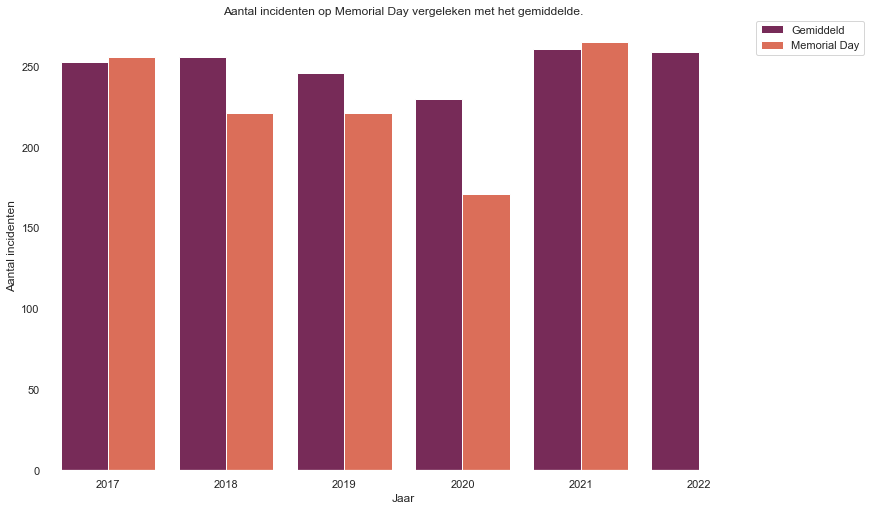

In [29]:
a4_dims = (12.7, 8.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(ax=ax, data=j1_mean_join, x="Jaar", y="Aantal incidenten", hue="Meetstaaf", palette="rocket").set(title='Aantal incidenten op Memorial Day vergeleken met het gemiddelde.')
plt.legend(bbox_to_anchor=(1.15, 1), loc='upper right', borderaxespad=0)
plt.show()

***
## Job Story 2: Zijn bepaalde misdaden meer gebeurd tijdens Memorial Day dan gemiddeld?

# Business understanding
De politiechef heeft ons gevraagd om te kijken of er bepaalde misdaden meer voorkomen tijdens Memorial Day dan gemiddeld.

# Data preperation
Hierboven aangeduid staat de dataset `memorialday_crime_df`. Dit gaan we dus gebruiken om te vergelijken. Ook hebben we de algemene dataset `crime_df`.

# Select data
Om te kunnen modelleren, hebben we een aantal gegevens nodig. Namelijk:
- Aantal incidenten op een normale dag per misdaad.
- Aantal incidenten op memorial day per misdaad.

In [15]:
# Om onafhankelijk aanpassingen te maken zijn nieuwe variabelen handig, vandaar een copy en een tag j2 (job story 2) aan het begin van het variabel
j2_memorialday_crime_df = memorialday_crime_df.copy()
j2_memorialday_offense_df = memorialday_offense_df.copy()
j2_crime_df = crime_df.copy()

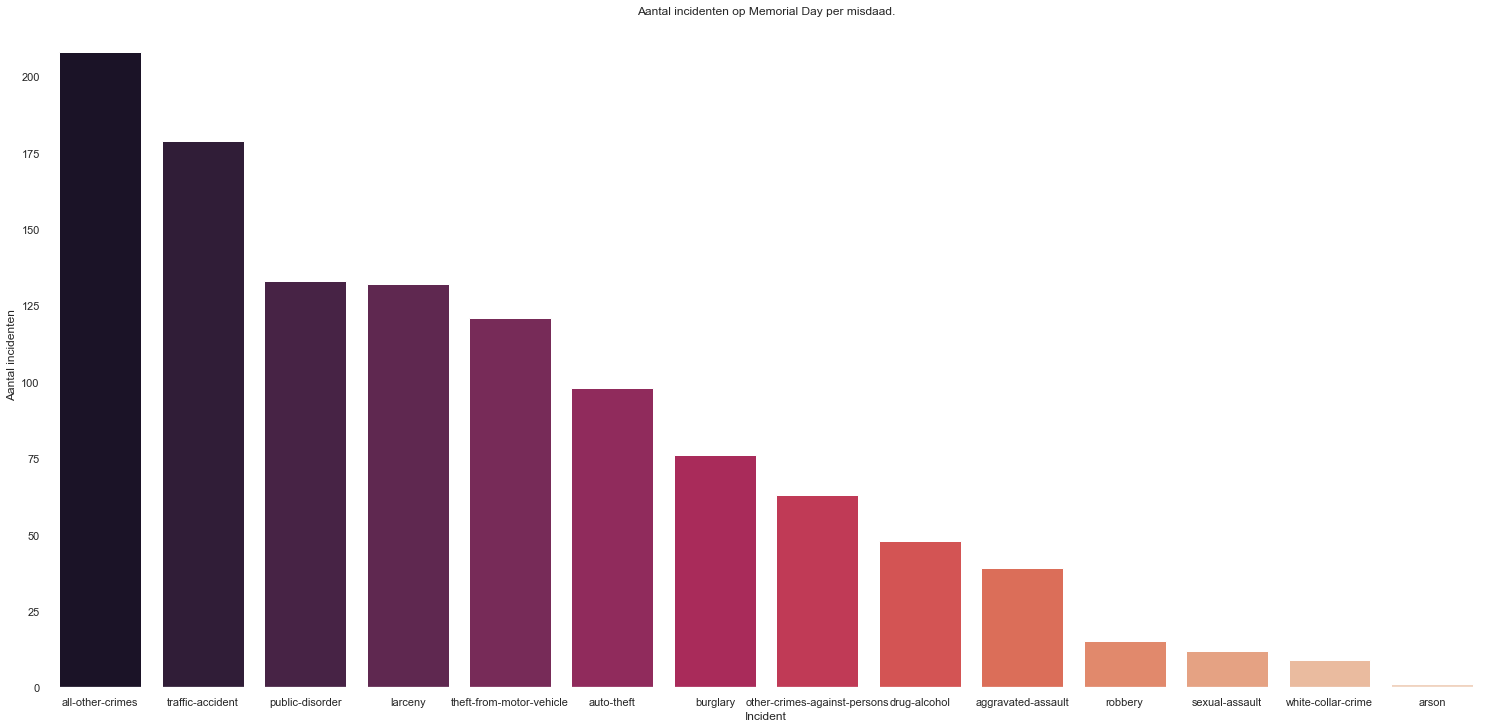

In [30]:
# Hier groepeer ik per misdaad en neem het aantal incidenten hiervan.
j2_offenses_memorialday = j2_memorialday_crime_df.groupby("OFFENSE_CATEGORY_ID").size().to_frame('size').reset_index()
j2_offenses_memorialday.columns = ["Incident", "Aantal incidenten"]
j2_offenses_memorialday["Type"] = "Memorial Day"

a4_dims = (25.7, 12.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(ax=ax, data=j2_offenses_memorialday, x="Incident", y="Aantal incidenten", palette="rocket", 
order=j2_offenses_memorialday.sort_values('Aantal incidenten',ascending = False).Incident).set(title='Aantal incidenten op Memorial Day per misdaad.')
plt.show()

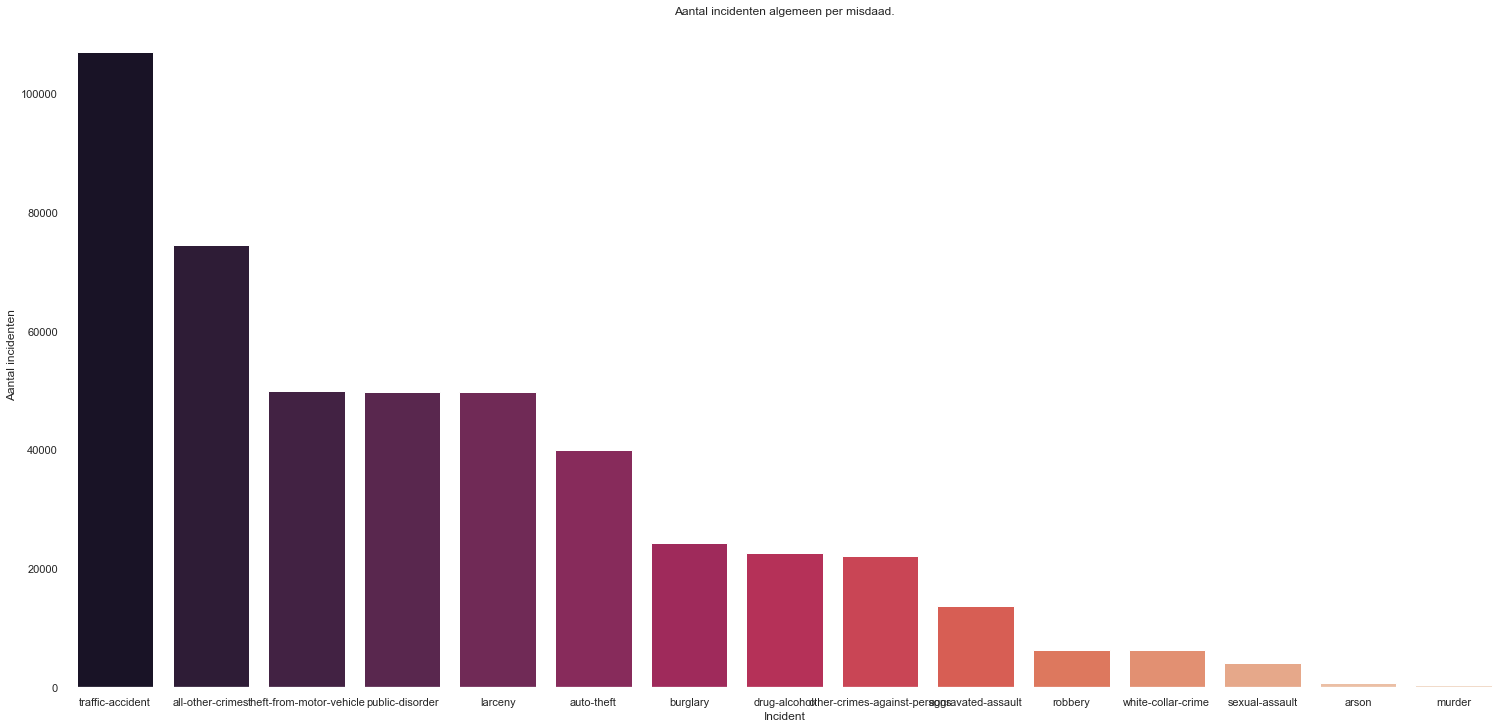

In [31]:
# Hier groepeer ik per misdaad en neem het aantal incidenten hiervan.
j2_offenses_all = j2_crime_df.groupby("OFFENSE_CATEGORY_ID").size().to_frame('size').reset_index()
j2_offenses_all.columns = ["Incident", "Aantal incidenten"]
j2_offenses_all["Type"] = "Gemiddeld"

a4_dims = (25.7, 12.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(ax=ax, data=j2_offenses_all, x="Incident", y="Aantal incidenten", palette="rocket", 
order=j2_offenses_all.sort_values('Aantal incidenten',ascending = False).Incident).set(title='Aantal incidenten algemeen per misdaad.')
plt.show()

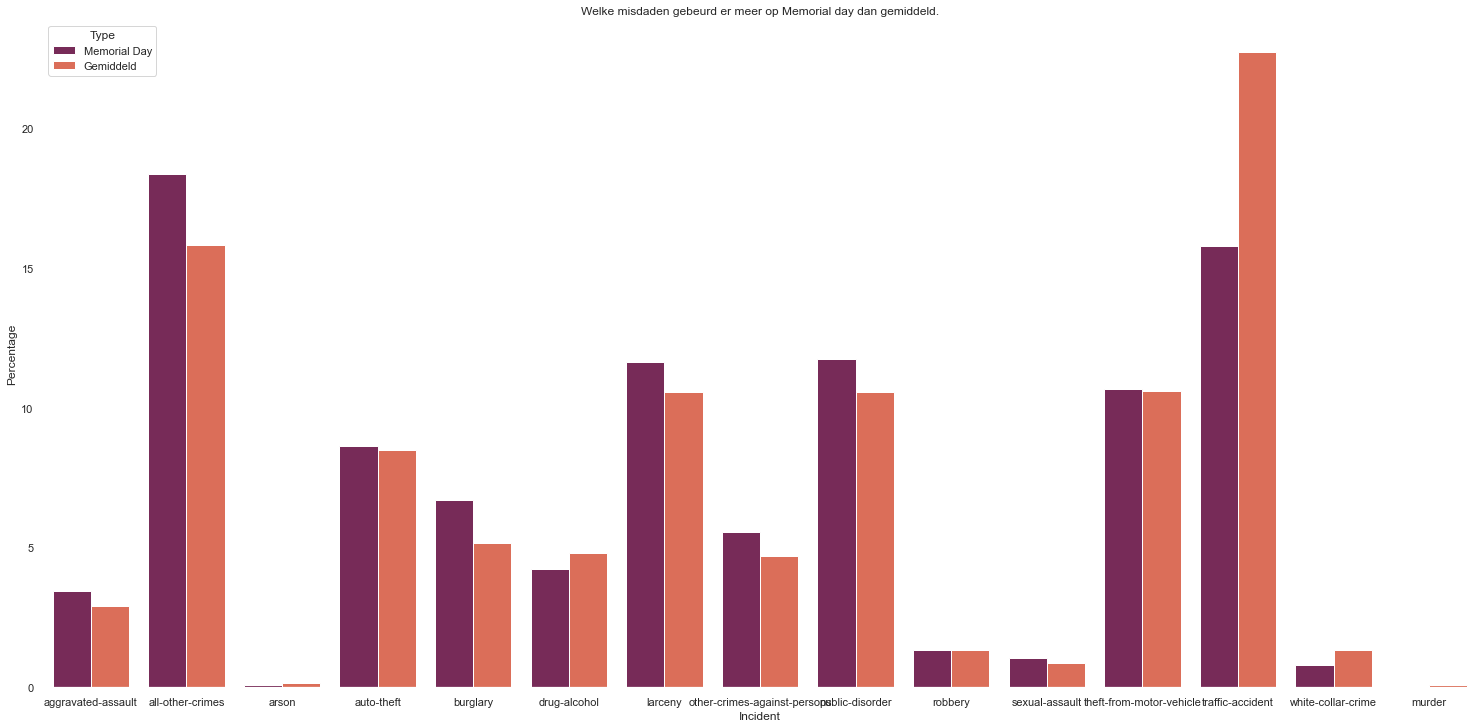

In [38]:
# Hier doe ik een magische formule om te kunnen vergelijken tussen kleine datasets en grote datasets
j2_offenses_memorialday["Percentage"] = j2_offenses_memorialday["Aantal incidenten"] / j2_offenses_memorialday["Aantal incidenten"].sum() * 100
j2_offenses_all["Percentage"] = j2_offenses_all["Aantal incidenten"] / j2_offenses_all["Aantal incidenten"].sum() * 100

# Voeg ze samen :D
j2_offenses_merged = pd.concat([j2_offenses_memorialday, j2_offenses_all])

a4_dims = (25.7, 12.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(ax=ax, data=j2_offenses_merged, x="Incident", y="Percentage", palette="rocket", hue="Type").set(title='Welke misdaden gebeurd er meer op Memorial day dan gemiddeld.')
plt.show()

***
## Job Story 3: In welke buurten is de misdaad tijdens Memorial day hoger dan gemiddeld?

# Business understanding
De politiechef heeft ons gevraagd om te kijken of er bepaalde buurten meer incidenten voorkomen tijdens Memorial Day dan gemiddeld.

# Data preperation
Hierboven aangeduid staat de dataset `memorialday_crime_df`. Dit gaan we dus gebruiken om te vergelijken. Ook hebben we de algemene dataset `crime_df`.

# Select data
Om te kunnen modelleren, hebben we een aantal gegevens nodig. Namelijk:
- Aantal incidenten op een normale dag per buurt.
- Aantal incidenten op memorial day per buurt.

In [20]:
# Om onafhankelijk aanpassingen te maken zijn nieuwe variabelen handig, vandaar een copy en een tag j2 (job story 2) aan het begin van het variabel
j3_memorialday_crime_df = memorialday_crime_df.copy()
j3_memorialday_offense_df = memorialday_offense_df.copy()
j3_crime_df = crime_df.copy()

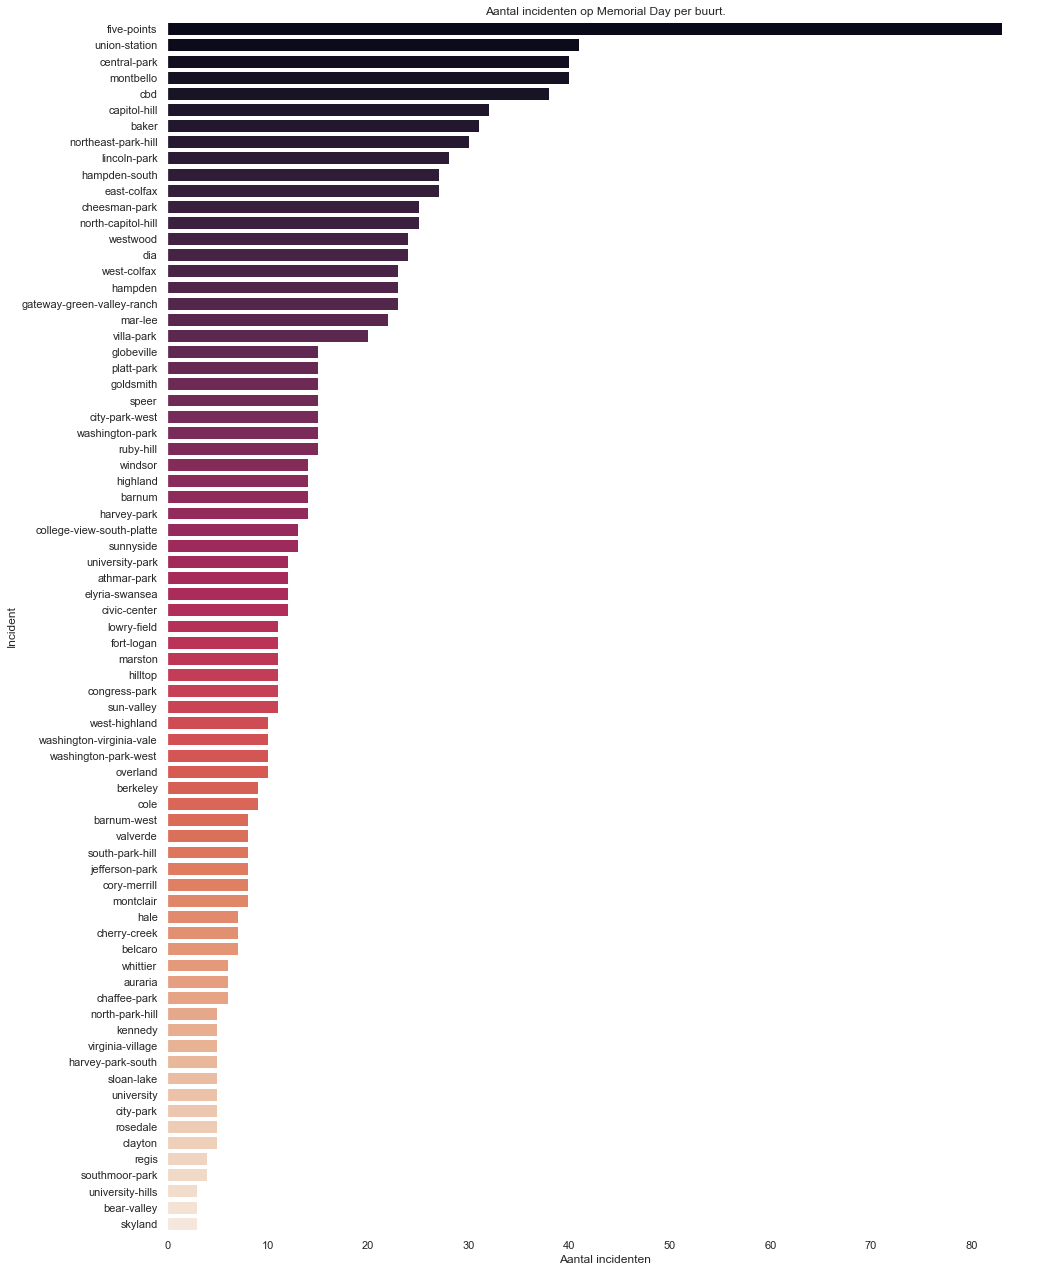

In [34]:
# Hier groepeer ik per misdaad en neem het aantal incidenten hiervan.
j3_offenses_memorialday = j3_memorialday_crime_df.groupby("NEIGHBORHOOD_ID").size().to_frame('size').reset_index()
j3_offenses_memorialday.columns = ["Incident", "Aantal incidenten"]
j3_offenses_memorialday["Type"] = "Memorial Day"

a4_dims = (15.7, 22.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(
    ax=ax, 
    data=j3_offenses_memorialday, 
    x="Aantal incidenten", 
    y="Incident", 
    palette="rocket", 
    order=j3_offenses_memorialday.sort_values('Aantal incidenten',ascending = False).Incident).set(title='Aantal incidenten op Memorial Day per buurt.')
    
plt.show()

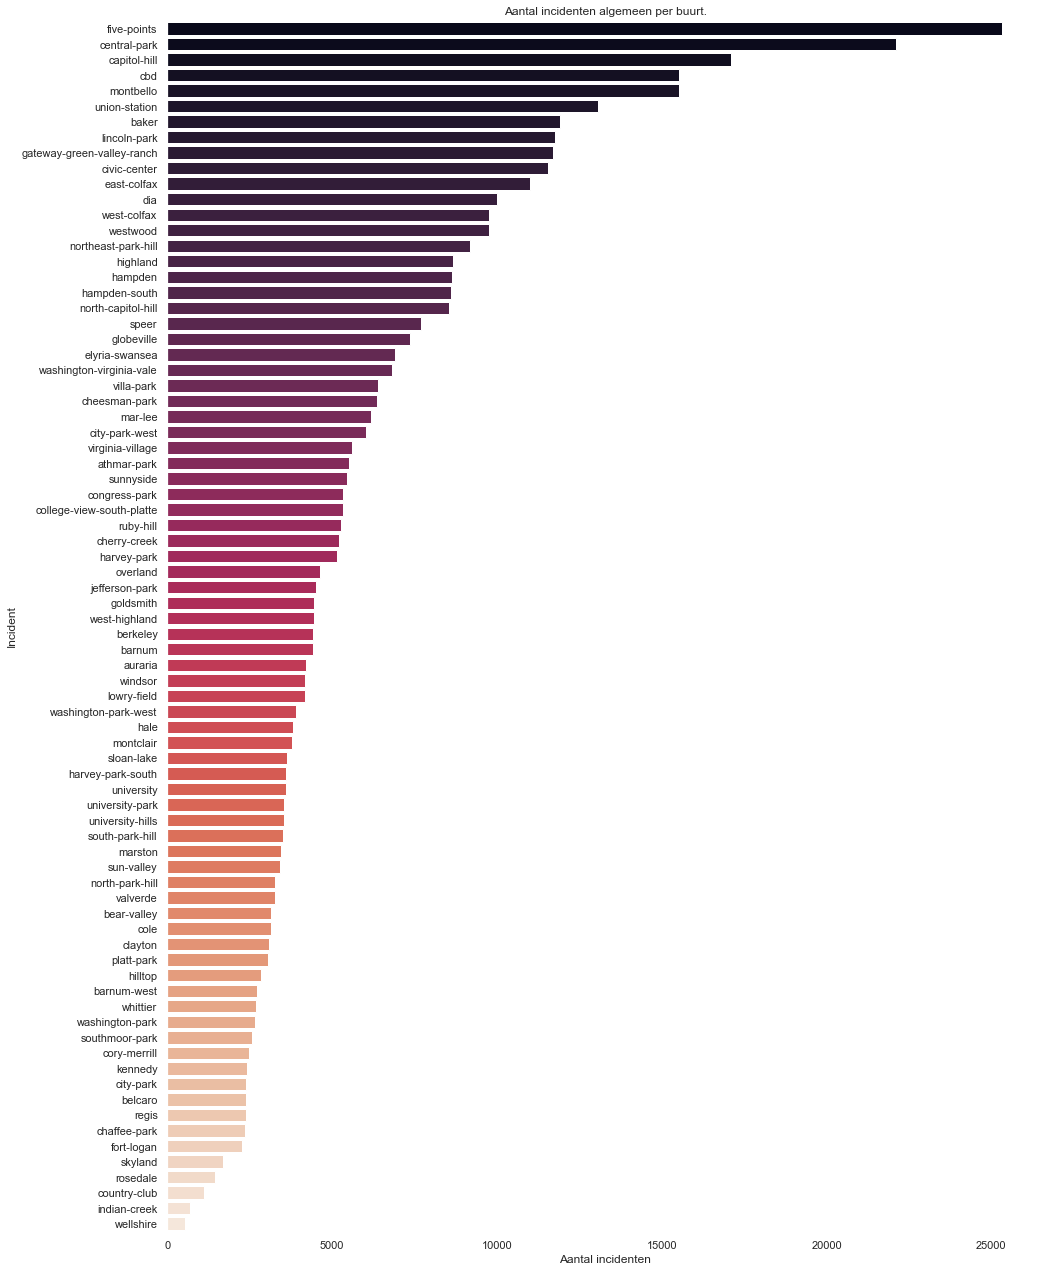

In [35]:
# Hier groepeer ik per misdaad en neem het aantal incidenten hiervan.
j3_offenses_all = j3_crime_df.groupby("NEIGHBORHOOD_ID").size().to_frame('size').reset_index()
j3_offenses_all.columns = ["Incident", "Aantal incidenten"]
j3_offenses_all["Type"] = "Gemiddeld"

a4_dims = (15.7, 22.27)
fig, ax = plt.subplots(figsize=a4_dims)
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
sns.barplot(
    ax=ax, 
    data=j3_offenses_all, 
    x="Aantal incidenten", 
    y="Incident", 
    palette="rocket", 
    order=j3_offenses_all.sort_values('Aantal incidenten',ascending = False).Incident).set(title='Aantal incidenten algemeen per buurt.')
    
plt.show()

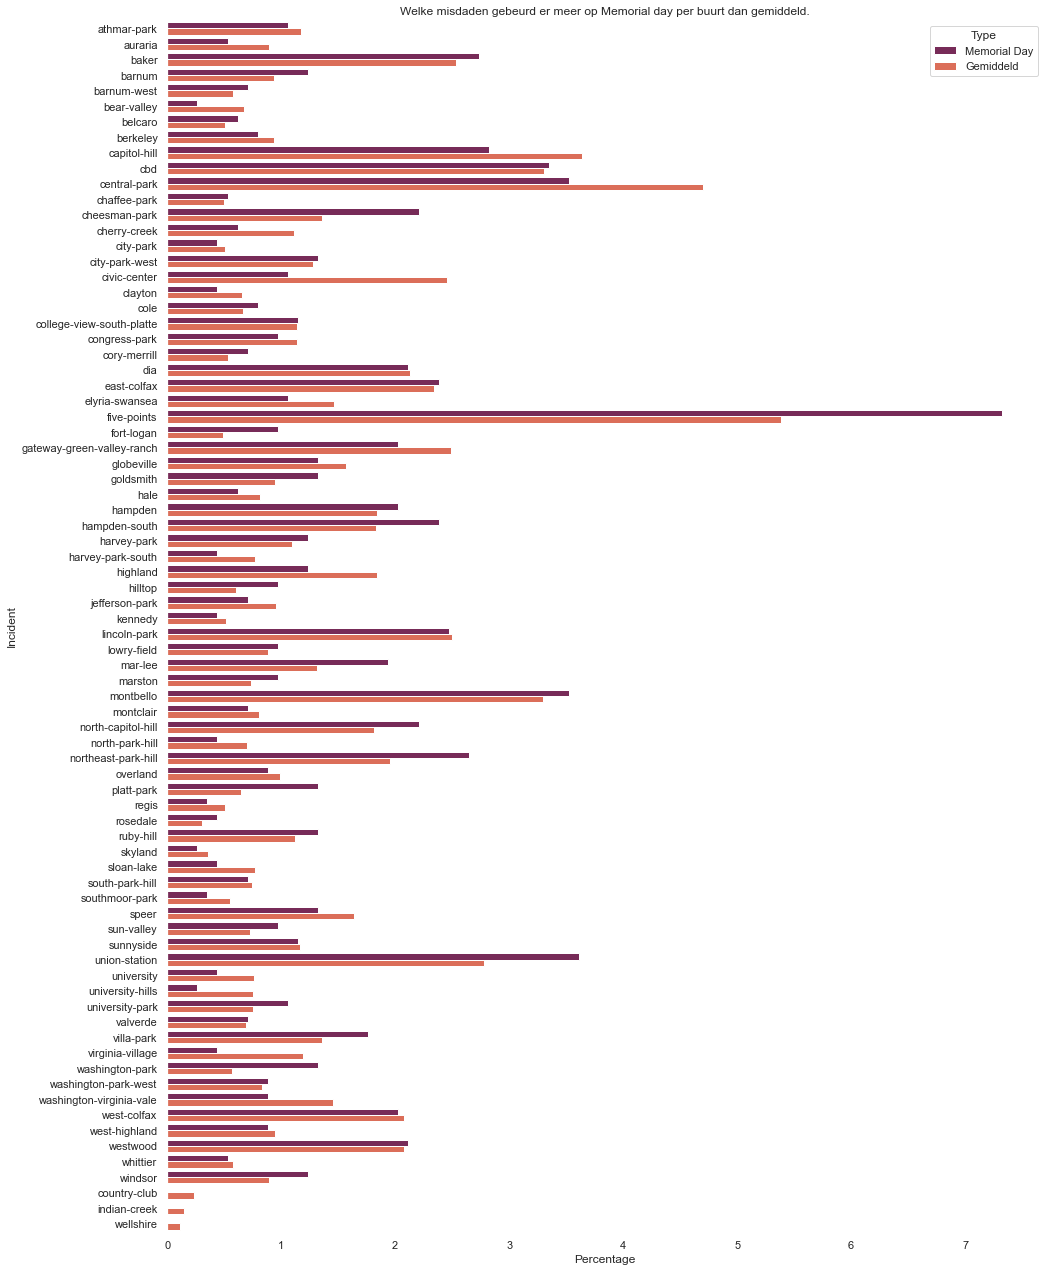

In [41]:
# Hier doe ik een magische formule om te kunnen vergelijken tussen kleine datasets en grote datasets
j3_offenses_memorialday["Percentage"] = j3_offenses_memorialday["Aantal incidenten"] / j3_offenses_memorialday["Aantal incidenten"].sum() * 100
j3_offenses_all["Percentage"] = j3_offenses_all["Aantal incidenten"] / j3_offenses_all["Aantal incidenten"].sum() * 100

# Voeg ze samen :D
j3_offenses_merged = pd.concat([j3_offenses_memorialday, j3_offenses_all])
sns.set(rc={'axes.facecolor':'white', 'figure.facecolor':'white'})
a4_dims = (15.7, 22.27)
fig, ax = plt.subplots(figsize=a4_dims)

sns.barplot(ax=ax, data=j3_offenses_merged, x="Percentage", y="Incident", palette="rocket", hue="Type").set(title='Welke misdaden gebeurd er meer op Memorial day per buurt dan gemiddeld.')
plt.show()